<a href="https://colab.research.google.com/github/tanjummotin/Pizza-vs-Ice-cream-classification-using-VGG-16/blob/main/Ice_cream_vs_PIzza_classification_with_CNN(VGG16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from google.colab.patches import cv2_imshow
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model



In [3]:
# Path to the zipped dataset file in Google Drive
zip_path = '/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/ice cream vs pizza.zip'

# Destination path to extract the dataset
extract_path = '/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/ice cream vs pizza'


In [8]:
# Extract the dataset
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [10]:
# Set the path to the extracted dataset directory
dataset_path = os.path.join(extract_path, 'dataset/train')

# Initialize empty lists to store image paths and corresponding labels
image_paths = []
labels = []

# Iterate over each subdirectory (each class)
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        # Iterate over each image in the subdirectory
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image_paths.append(image_path)
            labels.append(class_name)


In [11]:
# Create a dataframe from file names and class labels
data = {'Filepath': image_paths, 'Class': labels}
df = pd.DataFrame(data)

# Extract class labels
class_labels = df['Class'].unique()

# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['Class'], random_state=42)

In [12]:
# Create an ImageDataGenerator with data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1.0/255)

In [13]:
# Flow the data for training from training dataframe
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    x_col="Filepath",
                                                    y_col="Class",
                                                    target_size=(224, 224),
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    shuffle=True)

# Flow the data for validation from validation dataframe
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                x_col="Filepath",
                                                y_col="Class",
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                batch_size=32,
                                                class_mode='binary',
                                                shuffle=False)



Found 574 validated image filenames belonging to 2 classes.
Found 144 validated image filenames belonging to 2 classes.


In [14]:
# Load the VGG-16 model with pre-trained ImageNet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [25]:
# Configure and compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# Train the model
# Train the model
import pickle
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    epochs=50,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples//val_generator.batch_size,
                    verbose=1)

# Save the training history to a file
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/50
17/17 [==============================] - 13s 675ms/step - loss: 0.1958 - accuracy: 0.9151 - val_loss: 0.2045 - val_accuracy: 0.9297
Epoch 2/50
17/17 [==============================] - 12s 689ms/step - loss: 0.1904 - accuracy: 0.9173 - val_loss: 0.1914 - val_accuracy: 0.9297
Epoch 3/50
17/17 [==============================] - 12s 697ms/step - loss: 0.1738 - accuracy: 0.9373 - val_loss: 0.2255 - val_accuracy: 0.9219
Epoch 4/50
17/17 [==============================] - 11s 669ms/step - loss: 0.1272 - accuracy: 0.9502 - val_loss: 0.1794 - val_accuracy: 0.9453
Epoch 5/50
17/17 [==============================] - 12s 691ms/step - loss: 0.1323 - accuracy: 0.9465 - val_loss: 0.1856 - val_accuracy: 0.9453
Epoch 6/50
17/17 [==============================] - 12s 697ms/step - loss: 0.1477 - accuracy: 0.9336 - val_loss: 0.1776 - val_accuracy: 0.9453
Epoch 7/50
17/17 [==============================] - 11s 674ms/step - loss: 0.1291 - accuracy: 0.9428 - val_loss: 0.2612 - val_accuracy: 0.9062

In [26]:
# Save the entire model
model.save('/content/drive/MyDrive/DIP LAB/DIP_Lab3_Binary classification using SVM classifier/saved_VGG16_model_ep50.h5')

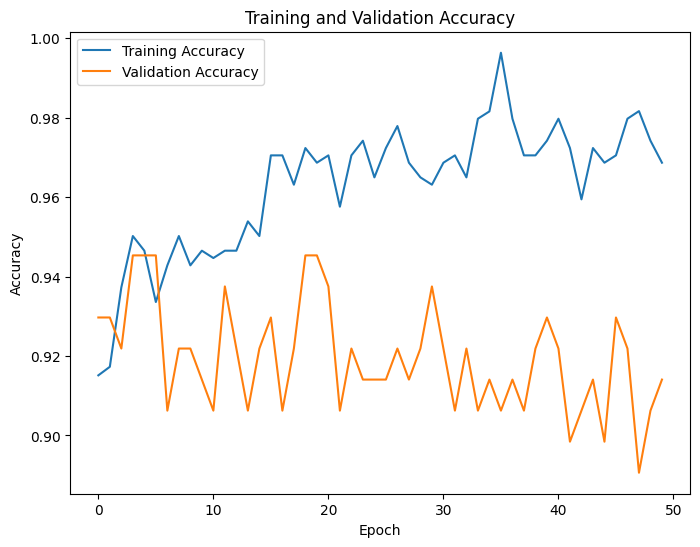

In [27]:
# Plot training and validation accuracy per epoch
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

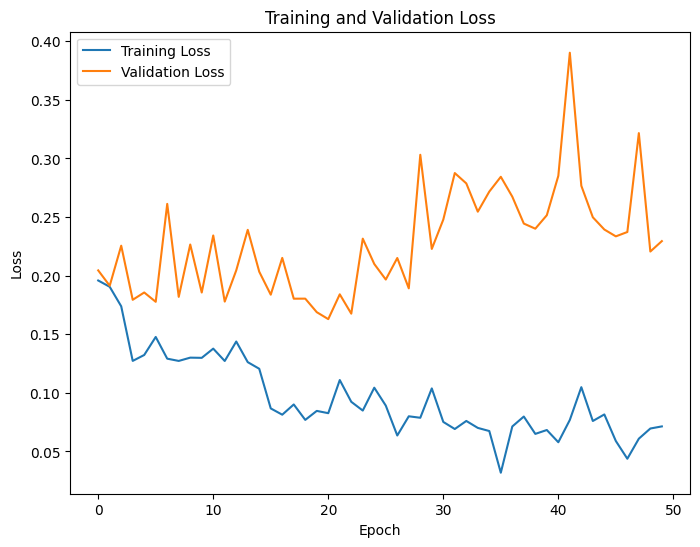

In [28]:
# Plot training and validation loss per epoch
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [29]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(val_generator)
print("Loss =", loss)
print("Accuracy =", accuracy)


5/5 [==============================] - 1s 160ms/step - loss: 0.2075 - accuracy: 0.9236
Loss = 0.2074548900127411
Accuracy = 0.9236111044883728


In [30]:
# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_true = val_generator.classes
y_pred_prob = model.predict(val_generator)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)



5/5 [==============================] - 1s 150ms/step
              precision    recall  f1-score   support

    icecream       0.95      0.91      0.93        78
       pizza       0.90      0.94      0.92        66

    accuracy                           0.92       144
   macro avg       0.92      0.92      0.92       144
weighted avg       0.92      0.92      0.92       144



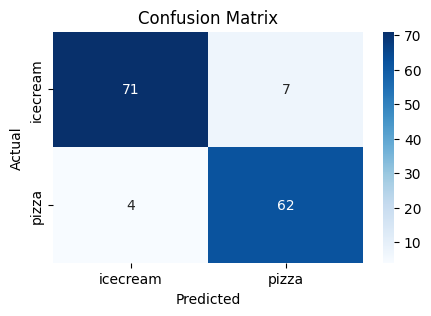

In [31]:
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap with labels and colored cells
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()